In [77]:
# import the standard numerical and plotting packages
import matplotlib.pyplot as plt
import numpy as np
from skimage.io import imread

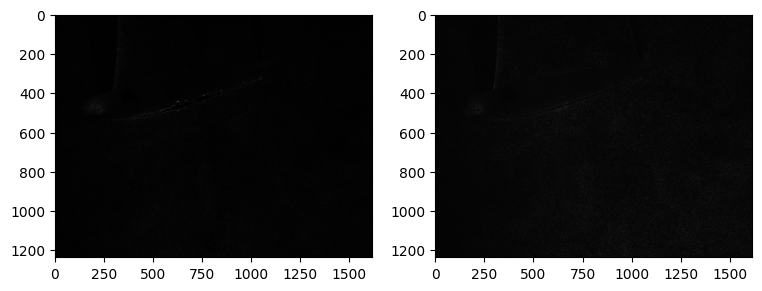

In [78]:
# load the images
im = imread("Pic1.tif")
a = im[:im.shape[0] // 2, :]
b = im[im.shape[0] // 2:, :]

fig, axs = plt.subplots(1, 2, figsize=(9, 4))
axs[0].imshow(a, cmap=plt.cm.gray)
axs[1].imshow(b, cmap=plt.cm.gray)
plt.show()


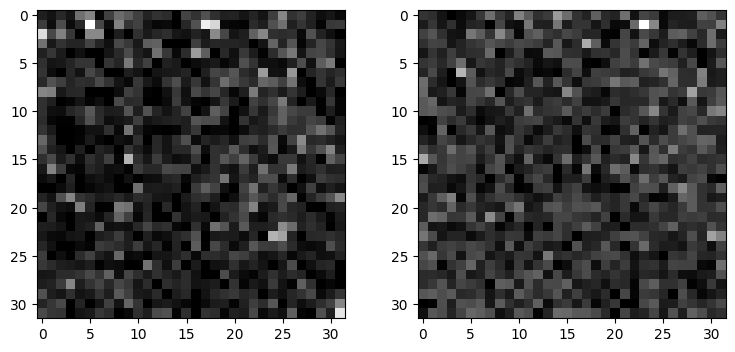

In [79]:
win_size = 32
a_win = a[:win_size, :win_size].copy()
b_win = b[:win_size, :win_size].copy()
fig, axs = plt.subplots(1, 2, figsize=(9, 4))
axs[0].imshow(a_win, cmap=plt.cm.gray)
axs[1].imshow(b_win, cmap=plt.cm.gray)
plt.show()


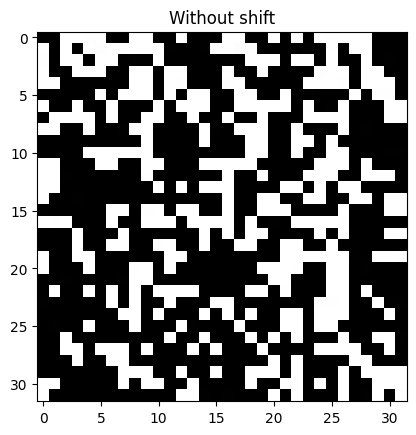

In [80]:
fig = plt.imshow(b_win - a_win, cmap=plt.cm.gray)
plt.title("Without shift")
plt.show()


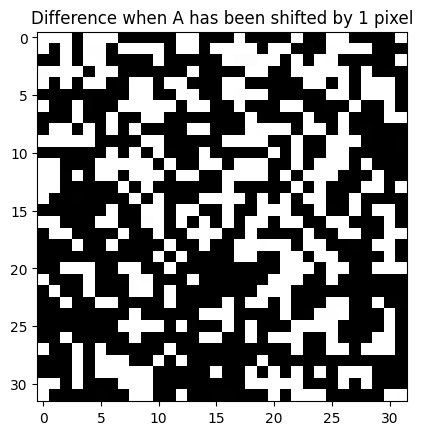

In [81]:
plt.imshow(b_win - np.roll(a_win, (1, 0), axis=(0, 1)), cmap=plt.cm.gray)
plt.title("Difference when A has been shifted by 1 pixel")
plt.show()

In [82]:
def match_template(img, template, maxroll=8):
    best_dist = np.inf
    best_shift = (-1, -1)
    for y in range(maxroll):
        for x in range(maxroll):
            # calculate Euclidean distance
            dist = np.sqrt(np.sum((img - np.roll(template, (y, x), axis=(0, 1))) **2))
        if dist < best_dist:
            best_dist = dist
            best_shift = (y, x)
    return (best_dist, best_shift)


In [83]:
match_template(np.roll(a_win, (2, 0), axis=(0, 1)), a_win)

(3539.33072769415, (5, 7))

In [84]:
# indeed, when we find the correct shift, we got zero distance. it's not so in real images
best_dist, best_shift = match_template(b_win, a_win)
print(f"{best_dist=}")
print(f"{best_shift=}")


best_dist=3539.495444268858
best_shift=(7, 7)


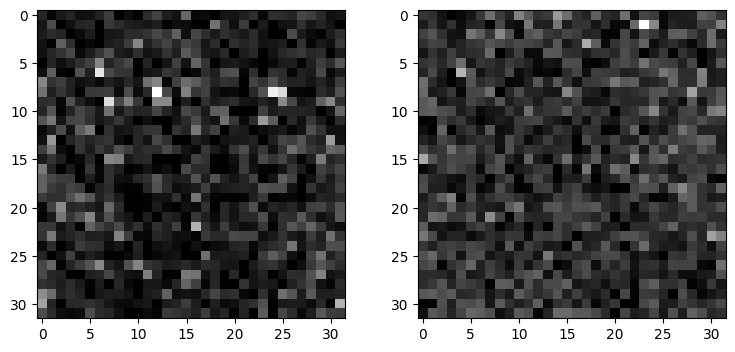

In [85]:
fig, axs = plt.subplots(1, 2, figsize=(9, 4))
axs[0].imshow(np.roll(a_win, best_shift, axis=(0, 1)), cmap='gray')
axs[1].imshow(b_win, cmap='gray')
plt.show()


In [86]:
from scipy.signal import correlate
cross_corr = correlate(b_win - b_win.mean(), a_win - a_win.mean(), method="fft")
# Note that it's approximately twice as large than the original windows, as we
# can shift a_win by a maximum of it's size - 1 horizontally and vertically
# while still maintaining some overlap between the two windows.
print("Size of the cross_corr map: %d x %d" % cross_corr.shape)


Size of the cross_corr map: 63 x 63


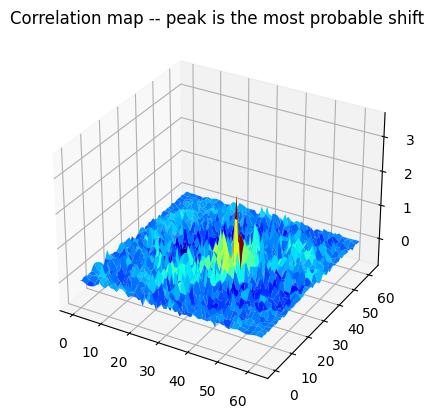

In [87]:
# let's see what the cross-correlation looks like
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(projection="3d")
Y_mesh, X_mesh = np.meshgrid(np.arange(cross_corr.shape[0]), np.arange(cross_corr.shape[1]))
ax.plot_surface(Y_mesh, X_mesh, cross_corr, cmap='jet', linewidth=0.2) # type: ignore
plt.title("Correlation map -- peak is the most probable shift")
plt.show()


y_max=31, x_max=37


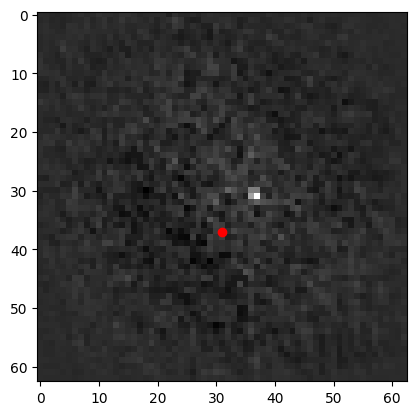

In [88]:
# let's see the same correlation map, from above
plt.imshow(cross_corr, cmap=plt.cm.gray)
y_max, x_max = np.unravel_index(cross_corr.argmax(), cross_corr.shape)
print(f"{y_max=}, {x_max=}")
plt.plot(y_max, x_max, "ro")
plt.show()


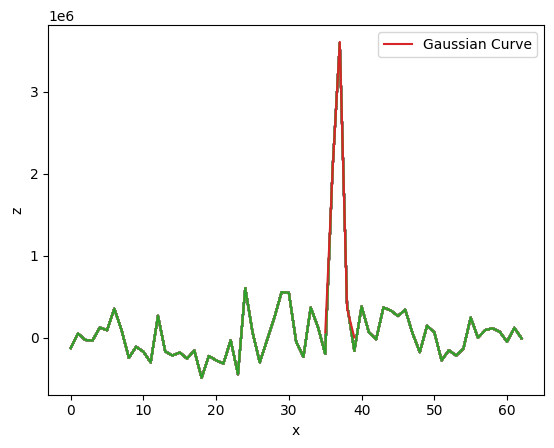

In [89]:
# Plot of cross correlation plane in x-z - peak at x_max
plt.plot(X_mesh,cross_corr[y_max][:])
x_max1 = x_max + 1
x_max2 = x_max - 1
x_max3 = x_max + 2
x_max4 = x_max - 2

maxi = cross_corr[y_max][x_max]
maxi_1x = cross_corr[y_max][x_max1]
maxi_2x = cross_corr[y_max][x_max2]
maxi_3x = cross_corr[y_max][x_max3]
maxi_4x = cross_corr[y_max][x_max4]

import numpy as np
from scipy.optimize import curve_fit

x_gaussian = np.array([x_max4,x_max2,x_max,x_max1,x_max3])
z_1 = np.array([maxi_4x, maxi_2x, maxi, maxi_1x, maxi_3x], dtype=float)

# Define the Gaussian function
def gaussian_function(x, a, b, c):
    return a * np.exp(-((x - b) / c) ** 2)

# Initial guess for the parameters [a, b, c]
mean = sum(x_gaussian * z_1)/sum(z_1)
sigma = np.sqrt(sum(z_1 * (x_gaussian - mean)**2)/sum(z_1))

# Fit the Gaussian function to the data
#fitparams, _ = curve_fit(gaussian_function, x_gaussian, z_1, p0=initial_guess, bounds=(0, [maxi, 10, 10]))
fitparams, _ = curve_fit(gaussian_function, x_gaussian, z_1, p0 = [0.1, mean, sigma])


# Extract the fitted parameters
A_x = fitparams[0]
mu_x = fitparams[1]
sigma_x = fitparams[2]
dx_subpix = x_max - mu_x

z_gaussian = gaussian_function(x_gaussian, A_x, mu_x, sigma_x)

plt.plot(x_gaussian, z_gaussian, label='Gaussian Curve')

# Add labels and legend
plt.xlabel('x')
plt.ylabel('z')
plt.legend()
plt.show()



In [90]:
y_max1 = y_max + 1
y_max2 = y_max - 1
y_max3 = y_max + 2
y_max4 = y_max - 2

maxi = cross_corr[y_max][x_max]
maxi_1y = cross_corr[y_max1][x_max]
maxi_2y = cross_corr[y_max2][x_max]
maxi_3y = cross_corr[y_max3][x_max]
maxi_4y = cross_corr[y_max4][x_max]

import numpy as np
from scipy.optimize import curve_fit

y_gaussian = np.array([y_max4,y_max2,y_max,y_max1,y_max3])
z_1 = np.array([maxi_4y, maxi_2y, maxi, maxi_1y, maxi_3y], dtype=float)

# Define the Gaussian function
def gaussian_function(x, a, b, c):
    return a * np.exp(-((x - b) / c) ** 2)

# Initial guess for the parameters [a, b, c]
mean = sum(y_gaussian * z_1)/sum(z_1)
sigma = np.sqrt(sum(z_1 * (y_gaussian - mean)**2)/sum(z_1))

# Fit the Gaussian function to the data
#fitparams, _ = curve_fit(gaussian_function, x_gaussian, z_1, p0=initial_guess, bounds=(0, [maxi, 10, 10]))
fitparams, _ = curve_fit(gaussian_function, y_gaussian, z_1, p0 = [0.1, mean, sigma])

# Extract the fitted parameters
A_y = fitparams[0]
mu_y = fitparams[1]
sigma_y = fitparams[2]
dy_subpix = y_max - mu_y

z_gaussian = gaussian_function(y_gaussian, A_y, mu_y, sigma_y)


In [91]:
def condition(x_max,y_max,correlation):
        # Conditions on x
    if (x_max < len(correlation) and x_max < len(correlation) - 1) and x_max > 2:
        # Analysis if x_max is within bounds of cross-correlation.
        maxi_1x = correlation[x_max - 2][y_max]
        maxi_2x = correlation[x_max - 1][y_max]
        maxi_3x = correlation[x_max + 1][y_max]
        maxi_4x = correlation[x_max + 2][y_max]
    elif x_max == len(correlation):
        # if peak is at the right edge of cross-correlation window
        maxi_1x = correlation[x_max - 2][y_max]
        maxi_2x = correlation[x_max - 1][y_max]
        maxi_3x = 0
        maxi_4x = 0
    elif x_max < 2 and x_max != 1:
        # if peak is on the right end of cross-correlation window
        maxi_1x = 0
        maxi_2x = correlation[x_max - 1][y_max]
        maxi_3x = 0
        maxi_4x = 0
    else:  # Should never be the case - but put just in case
        maxi_1x = 0
        maxi_2x = 0
        maxi_3x = 0
        maxi_4x = 0

    # Conditions on y
    if (y_max < len(correlation) and y_max < len(correlation) - 1) and y_max > 2:
        # Analysis if y_max is within bounds of cross-correlation.
        maxi_1y = correlation[x_max][y_max - 2]
        maxi_2y = correlation[x_max][y_max - 1]
        maxi_3y = correlation[x_max][y_max + 1]
        maxi_4y = correlation[x_max][y_max + 2]
    elif y_max == len(correlation):
        # if peak is at the right edge of cross-correlation window
        maxi_1y = correlation[x_max][y_max - 2]
        maxi_2y = correlation[x_max][y_max - 1]
        maxi_3y = 0
        maxi_4y = 0
    elif y_max < 2 and y_max != 1:
        # if peak is on the right end of cross-correlation window
        maxi_1y = 0
        maxi_2y = correlation[x_max][y_max - 1]
        maxi_3y = 0
        maxi_4y = 0
    else:  # Should never be the case - but put just in case
        maxi_1y = 0
        maxi_2y = 0
        maxi_3y = 0
        maxi_4y = 0
    return maxi,maxi_1x,maxi_2x,maxi_3x,maxi_4x,maxi_1y,maxi_2y,maxi_3y,maxi_4y

In [92]:
# Define the Gaussian function
def gaussian_function(x, a, b, c):
    return a * np.exp(-((x - b) / c) ** 2)

def subpixel(x_max,y_max,cross_corr):
    maxi,maxi_1x,maxi_2x,maxi_3x,maxi_4x,maxi_1y,maxi_2y,maxi_3y,maxi_4y = condition(x_max,y_max,cross_corr)
    x_max1 = x_max + 1
    x_max2 = x_max - 1
    x_max3 = x_max + 2
    x_max4 = x_max - 2

    import numpy as np
    from scipy.optimize import curve_fit

    x_gaussian = np.array([x_max4,x_max2,x_max,x_max1,x_max3])
    z_1 = np.array([maxi_4x, maxi_2x, maxi, maxi_1x, maxi_3x], dtype=float)

    # Initial guess for the parameters [a, b, c]
    mean = sum(x_gaussian * z_1)/sum(z_1)
    sigma = np.sqrt(sum(z_1 * (x_gaussian - mean)**2)/sum(z_1))

    # Fit the Gaussian function to the data
    fitparams, _ = curve_fit(gaussian_function, x_gaussian, z_1, p0 = [0.1, mean, sigma])
    
    mu_x = fitparams[1]

    y_max1 = y_max + 1
    y_max2 = y_max - 1
    y_max3 = y_max + 2
    y_max4 = y_max - 2

    y_gaussian = np.array([y_max4,y_max2,y_max,y_max1,y_max3])
    z_1 = np.array([maxi_4y, maxi_2y, maxi, maxi_1y, maxi_3y], dtype=float)
    # Initial guess for the parameters [a, b, c]
    mean = sum(y_gaussian * z_1)/sum(z_1)
    sigma = np.sqrt(sum(z_1 * (y_gaussian - mean)**2)/sum(z_1))

    # Fit the Gaussian function to the data
    #fitparams, _ = curve_fit(gaussian_function, x_gaussian, z_1, p0=initial_guess, bounds=(0, [maxi, 10, 10]))
    fitparams, _ = curve_fit(gaussian_function, y_gaussian, z_1, p0 = [0.1, mean, sigma])

    mu_y = fitparams[1]
    
    return mu_x,mu_y

In [93]:
dy, dx = y_max - 31, x_max - 31
print(f"{dy=}, {dx=}")

dy=0, dx=6


In [94]:
def vel_field(curr_frame, next_frame, win_size):
    ys = np.arange(0, curr_frame.shape[0], win_size)
    xs = np.arange(0, curr_frame.shape[1], win_size)
    dys = np.zeros((len(ys), len(xs)))
    dxs = np.zeros((len(ys), len(xs)))
    for iy, y in enumerate(ys):
        for ix, x in enumerate(xs):
            int_win = curr_frame[y : y + win_size, x : x + win_size]
            search_win = next_frame[y : y + win_size, x : x + win_size]
            cross_corr = correlate( search_win - search_win.mean(), int_win - int_win.mean(), method="fft")
            y_max, x_max = np.unravel_index(cross_corr.argmax(), cross_corr.shape)
            dys[iy, ix], dxs[iy, ix] = (np.unravel_index(np.argmax(cross_corr), cross_corr.shape) - np.array([win_size, win_size])+ 1)
            #mu_x, mu_y = subpixel(x_max,y_max,cross_corr)
            #dys[iy,ix], dxs[iy,ix] = mu_y - 31, mu_x - 31
            
    # draw velocity vectors from the center of each window
    ys = ys + win_size / 2
    xs = xs + win_size / 2
    return xs, ys, dxs, dys


In [95]:
xs, ys, dxs, dys = vel_field(a, b, 32)

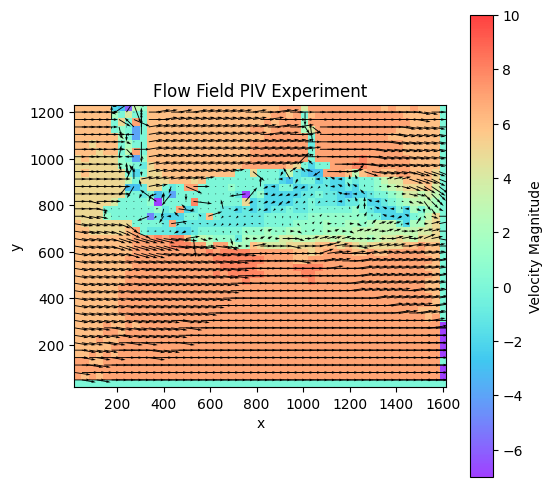

<Figure size 640x480 with 0 Axes>

In [96]:
pitch = 4.4*10e-6
time = 73*10e-6
M = 0.04

xs, ys, dxs, dys = vel_field(a, b, 32)
u = dxs*pitch/(M*time)
v = dys*pitch/(M*time)

norm_drs = np.sqrt(dxs ** 2 + dys ** 2)
dxs[norm_drs > 9] = 0
dys[norm_drs > 9] = 0

v = np.sign(dxs)*norm_drs*pitch/(M*time)
fig, ax = plt.subplots(figsize=(6, 6))
v_min = -7
v_max  = 10
# Add the heatmap of velocities as an overlay
heatmap = ax.imshow(dxs, extent=(xs.min(), xs.max(), ys.min(), ys.max()), cmap='rainbow', alpha=0.75,vmin=v_min, vmax=v_max)
# Add a colorbar for the heatmap
cbar = plt.colorbar(heatmap, label='Velocity Magnitude')

# we need these flips on y since quiver uses a bottom-left origin, while our
# arrays use a top-right origin
ax.quiver(xs, ys[::-1], dxs, -dys, cmap="plasma", angles="xy", scale_units="xy", scale=0.1)
ax.set_aspect("equal")
plt.xlabel('x')
plt.ylabel('y')
plt.title('Flow Field PIV Experiment')
plt.show()
plt.savefig('output.png')

In [97]:
mean_v = np.mean(v)
rms_v = np.sqrt(np.mean(v**2))

print('mean value', mean_v)
print('RMS value',rms_v)

mean value 7.4921428768434115
RMS value 8.89566824450894


In [98]:
# Read the data from the file
data = np.loadtxt('B00002_15deg_Int32.dat', skiprows=3)  # Assuming the data is stored in 'data.dat' file
#data = np.loadtxt('B00002.dat', skiprows=3)  # Assuming the data is stored in 'data.dat' file

# Extract the variables
x = data[:, 0]
y = data[:, 1]
Vx = data[:, 2]
Vy = data[:, 3]
isValid = data[:, 4]

filename = 'B00002_15deg_Int32.dat'  # Replace with the actual file path
#filename = 'B00002.dat'  # Replace with the actual file path

with open(filename, 'r') as file:
    lines = file.readlines()

third_line = lines[2].strip()  # Get the 3rd line and remove leading/trailing whitespace

values = third_line.split()  # Split the line into individual values

i_value = None
j_value = None

for value in values:
    if value.startswith("I="):
        i_value = int(value[2:].replace(',', ''))  # Extract the integer value after "I=" and remove the comma
    elif value.startswith("J="):
        j_value = int(value[2:].replace(',', ''))  # Extract the integer value after "J=" and remove the comma

print("I value:", i_value)
print("J value:", j_value)


I value: 101
J value: 78


In [99]:

# Reshape the variables to match the grid size
grid_size = (i_value, j_value)
x_mesh = x.reshape(grid_size)
y_1 = y[::j_value]
y_t = y_1*np.ones((j_value,i_value))
y_mesh = y_t.T
Vx_mesh = Vx.reshape(grid_size)
Vy_mesh = Vy.reshape(grid_size)
isValid = isValid.reshape(grid_size)

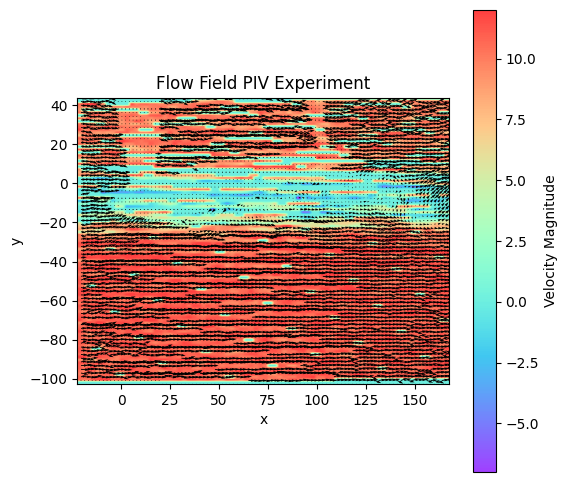

<Figure size 640x480 with 0 Axes>

In [100]:
norm_data = np.sqrt(Vx_mesh ** 2 + Vy_mesh ** 2)
v_data = np.sign(Vx_mesh)*norm_data
fig, ax = plt.subplots(figsize=(6, 6))
v_min = -7
v_max  = 12
# Add the heatmap of velocities as an overlay
heatmap = ax.imshow(Vx_mesh, extent=(x_mesh.min(), x_mesh.max(), y_mesh.min(), y_mesh.max()), cmap='rainbow', alpha=0.75,vmin=v_min, vmax=v_max)
# Add a colorbar for the heatmap
cbar = plt.colorbar(heatmap, label='Velocity Magnitude')

# we need these flips on y since quiver uses a bottom-left origin, while our
# arrays use a top-right origin
ax.quiver(x_mesh, y_mesh, Vx_mesh, -Vy_mesh, cmap="plasma", angles="xy", scale_units="xy", scale=3)
ax.set_aspect("equal")
plt.xlabel('x')
plt.ylabel('y')
plt.title('Flow Field PIV Experiment')
plt.show()
plt.savefig('output1.png')

In [101]:
mean_v = np.mean(v_data)
rms_v = np.sqrt(np.mean(v_data**2))

print('mean value', mean_v)
print('RMS value',rms_v)

mean value 8.128670646294083
RMS value 9.329509503051396
